In [1]:
#!pip install textblob
import nltk
from nltk.tokenize import word_tokenize  
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [5]:
import pandas as pd
df = pd.read_csv('data/final_df.csv')
#print(df.to_string())
df.head()

,feedback_created_at,final_msg_join,feedback_message
0,2017-11-10 08:00:18,top,Top
1,2017-11-10 08:51:40,blinker defect break delay,"blinker defect, break work delayed"
2,2017-11-10 08:43:30,app really well,App did not work really well
3,2017-11-10 09:51:10,ending ride first attempt start app try,Ending ride didn’t work at first attempt. I ha...
4,2017-11-10 10:04:59,battery keep change level dramatically,Battery kept changing its level dramatically.


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12414 entries, 0 to 12413
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   feedback_created_at  12414 non-null  object
 1   final_msg_join       12359 non-null  object
 2   feedback_message     12414 non-null  object
dtypes: object(3)
memory usage: 291.1+ KB


In [25]:
df['Date']= pd.to_datetime(df['feedback_created_at'])
df['final_msg_join'] = df['final_msg_join'].astype(str)

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12414 entries, 0 to 12413
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   feedback_created_at  12414 non-null  object        
 1   final_msg_join       12414 non-null  object        
 2   feedback_message     12414 non-null  object        
 3   Date                 12414 non-null  datetime64[ns]
 4   year                 12414 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 485.0+ KB


In [14]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df.head()

,feedback_created_at,final_msg_join,feedback_message,Date,year
0,2017-11-10 08:00:18,top,Top,2017-11-10 08:00:18,2017
1,2017-11-10 08:51:40,blinker defect break delay,"blinker defect, break work delayed",2017-11-10 08:51:40,2017
2,2017-11-10 08:43:30,app really well,App did not work really well,2017-11-10 08:43:30,2017
3,2017-11-10 09:51:10,ending ride first attempt start app try,Ending ride didn’t work at first attempt. I ha...,2017-11-10 09:51:10,2017
4,2017-11-10 10:04:59,battery keep change level dramatically,Battery kept changing its level dramatically.,2017-11-10 10:04:59,2017


### How many messages are there for each year?

<AxesSubplot:xlabel='year'>

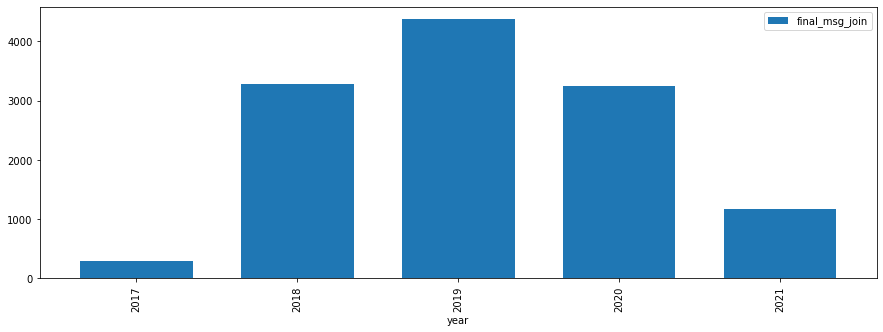

In [20]:
%matplotlib inline
df.groupby('year').agg({'final_msg_join': 'count'}).plot.bar(figsize=(15,5),width=0.7)

### Preparation - getting ready for the analysis

In [28]:
import spacy
nlp = spacy.load('en_core_web_sm')

df['final_msg_join_tok'] = df['final_msg_join'].map(nlp)

In [34]:
df['final_msg_join_tok'][0]

top

In [36]:
def lemma(doc):
    doclems = [t.lemma_ for t in doc]
    return doclems
df['final_msg_join_tok'] = df['final_msg_join_tok'].map(lemma)

In [39]:
#df['final_msg_join_tok']

0                                                    [top]
1                          [blinker, defect, break, delay]
2                                      [app, really, well]
3             [end, ride, first, attempt, start, app, try]
4             [battery, keep, change, level, dramatically]
                               ...                        
12409                                [handlebar, straight]
12410                                      [app, properly]
12411    [open, button, helmet, also, previous, driver,...
12412                                   [hunchback, stick]
12413                                    [wo, speed, fast]
Name: final_msg_join_tok, Length: 12414, dtype: object

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords


tfidf_text = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
vectors_text = tfidf_text.fit_transform(df['final_msg_join'])
vectors_text.shape


(12414, 993)

In [45]:
vectors_text

<12414x993 sparse matrix of type '<class 'numpy.float64'>'
	with 45191 stored elements in Compressed Sparse Row format>

In [47]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=7, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(vectors_text)
H_text_matrix = nmf_text_model.components_

C:\Users\T430\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [50]:
def display_topics(model, features, no_top_words=5):
    for topic, word_vector in enumerate(model.components_):
        total = word_vector.sum()
        largest = word_vector.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]],
                word_vector[largest[i]]*100.0/total))

In [54]:
display_topics(nmf_text_model, tfidf_text.get_feature_names())


Topic 00
  helmet (46.85)
  box (3.09)
  small (2.40)
  size (2.33)
  miss (2.21)

Topic 01
  battery (47.04)
  low (8.57)
  run (1.96)
  dead (1.61)
  slow (1.41)

Topic 02
  open (37.34)
  case (19.68)
  box (10.67)
  trunk (2.72)
  close (1.68)

Topic 03
  scooter (29.79)
  stop (2.83)
  find (2.33)
  start (2.12)
  drive (1.84)

Topic 04
  break (29.06)
  mirror (6.87)
  left (4.10)
  properly (1.76)
  loose (1.61)

Topic 05
  great (67.26)
  service (3.44)
  experience (2.10)
  ride (2.00)
  thank (1.62)

Topic 06
  ride (9.88)
  perfect (4.42)
  bike (3.46)
  minute (3.35)
  app (2.79)


In [55]:
#size of topics, % of whole corupus
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([14.46927425, 10.12269339, 13.555498  , 15.0579352 , 17.67483459,
        7.06796875, 22.05179582])

In [ ]:
#svd

In [59]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 7, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(vectors_text)
H_svd_para_matrix = svd_para_model.components_

In [60]:
display_topics(svd_para_model, tfidf_text.get_feature_names())


Topic 00
  helmet (15.96)
  open (11.55)
  case (6.47)
  box (4.46)
  break (4.05)

Topic 01
  battery (19.92)
  scooter (7.09)
  break (4.68)
  low (3.68)
  stop (1.88)

Topic 02
  break (31.41)
  helmet (25.89)
  scooter (15.69)
  mirror (6.74)
  left (4.07)

Topic 03
  scooter (17.19)
  open (7.48)
  break (5.46)
  case (4.09)
  ride (3.04)

Topic 04
  break (131.18)
  mirror (33.43)
  open (26.84)
  case (23.70)
  left (19.65)

Topic 05
  great (51.93)
  ride (11.83)
  thank (2.93)
  service (2.79)
  perfect (2.18)

Topic 06
  case (13.70)
  ride (9.70)
  close (5.76)
  perfect (5.51)
  minute (4.53)


In [63]:
svd_para_model.singular_values_

array([22.17579206, 17.7659463 , 16.95764466, 16.01962386, 14.9536378 ,
       14.42428474, 12.75541716])

In [ ]:
##lda

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5,
                        max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(df["final_msg_join"])

In [72]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 7, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [73]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
  battery (17.69)
  helmet (10.86)
  break (5.02)
  low (4.07)
  perfect (4.02)

Topic 01
  moto (6.16)
  bike (3.98)
  indicator (2.92)
  dirty (2.59)
  head (2.55)

Topic 02
  scooter (13.72)
  start (4.28)
  ride (3.93)
  minute (3.75)
  app (3.16)

Topic 03
  helmet (15.70)
  open (12.03)
  case (7.40)
  close (4.44)
  box (4.06)

Topic 04
  break (10.56)
  good (5.89)
  stop (4.11)
  turn (3.70)
  light (3.51)

Topic 05
  mirror (9.90)
  loose (4.45)
  left (4.07)
  thank (3.87)
  fix (3.59)

Topic 06
  wheel (4.89)
  scooter (4.81)
  drive (4.19)
  noise (3.61)
  km (3.35)


In [138]:
top_terms=20
TOTAL_TOPICS = 7

vocabulary = np.array(count_para_vectorizer.get_feature_names())
topic_terms = lda_para_model.components_
topic_key_term_idxs = np.argsort(-np.absolute(topic_terms), axis=1)[:,:top_terms]
topic_keyterms = vocabulary[topic_key_term_idxs]
topics = [', '.join(topic) for topic in topic_keyterms]
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame(topics, columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, TOTAL_TOPICS+1)])
topics_df

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-138-22290d158211>:9: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,Terms per Topic
Topic1,"battery, helmet, break, low, perfect, damage, miss, inside, refund, super, bad, ride, key, change, leave, condition, cool, strap, vice, smooth"
Topic2,"moto, bike, indicator, dirty, head, cover, trip, leave, seat, run, want, hair, mark, easy, old, topcase, fool, clean, vehicle, wet"
Topic3,"scooter, start, ride, minute, app, stop, charge, find, trip, second, bike, min, problem, lose, end, way, stand, refund, try, wait"
Topic4,"helmet, open, case, close, box, great, ride, lock, clock, app, minute, button, try, trunk, small, love, able, size, money, properly"
Topic5,"break, good, stop, turn, light, dangerous, bike, left, bit, ride, bad, middle, road, brake, hard, properly, check, traffic, rear, nice"
Topic6,"mirror, loose, left, thank, fix, break, slow, service, leave, expensive, area, bike, gun, broken, little, amazing, great, app, parking, awesome"
Topic7,"wheel, scooter, drive, noise, km, check, speed, feel, weird, flat, sound, rake, fast, tire, accelerate, dangerous, wrong, bit, safe, strange"


In [149]:
document_topics = W_lda_para_matrix
dt_df = pd.DataFrame(document_topics, columns=['T'+str(i) for i in range(1, TOTAL_TOPICS+1)])

pd.options.display.float_format = '{:,.5f}'.format
pd.set_option('display.max_colwidth', 200)
max_contrib_topics = dt_df.max(axis=0)
dominant_topics = max_contrib_topics.index
contrib_perc = max_contrib_topics.values
document_numbers = [dt_df[dt_df[t] == max_contrib_topics.loc[t]].index[0] for t in dominant_topics]

documents = [df['feedback_message'].loc[i] for i in document_numbers]
results_df = pd.DataFrame({'Dominant Topic': dominant_topics, 'Contribution%': contrib_perc,'Paper Num': document_numbers, 'Topic': topics_df['Terms per Topic'],'Paper Name': documents})
results_df

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant Topic,Contribution%,Paper Num,Topic,Paper Name
Topic1,T1,0.91397,9834,"battery, helmet, break, low, perfect, damage, miss, inside, refund, super, bad, ride, key, change, leave, condition, cool, strap, vice, smooth","Moto has a previous little damage, acceleration was not grate. I have picture of. Previous little damage"
Topic2,T2,0.93402,3269,"moto, bike, indicator, dirty, head, cover, trip, leave, seat, run, want, hair, mark, easy, old, topcase, fool, clean, vehicle, wet","All the seats of every moto is ALWAYS WET, it’s disgusting, you need to improve this , every morning I leave the moto and all my clothes where I sat on are wet, the seats have water for days"
Topic3,T3,0.95485,3871,"scooter, start, ride, minute, app, stop, charge, find, trip, second, bike, min, problem, lose, end, way, stand, refund, try, wait","Hi, this was actually a very frustrating trip. When I arrived at the scooter, I could not unlock and start. I restarted my app twice and it didn’t work, I then restarted my phone, and finally I h..."
Topic4,T4,0.94951,6741,"helmet, open, case, close, box, great, ride, lock, clock, app, minute, button, try, trunk, small, love, able, size, money, properly","Even though the locker for the helmets was properly closed, the app would keep telling me it wasn’t. I’ve spend a few minutes trying to re close it only for the app to tell me it still wasn’t clos..."
Topic5,T5,0.92203,5845,"break, good, stop, turn, light, dangerous, bike, left, bit, ride, bad, middle, road, brake, hard, properly, check, traffic, rear, nice","The motorcycle is in vad shape - every time you stop the engine is turned off and you have to manipulate the brake and ""gas"" for it to turn on again, while everyone behind you honk. Also dangerous!"
Topic6,T6,0.91412,4315,"mirror, loose, left, thank, fix, break, slow, service, leave, expensive, area, bike, gun, broken, little, amazing, great, app, parking, awesome","There never used to be any issues with the server. But lately the app sometimes takes a long time to connect to the server, or doesn't connect at all... Pity."
Topic7,T7,0.92849,5630,"wheel, scooter, drive, noise, km, check, speed, feel, weird, flat, sound, rake, fast, tire, accelerate, dangerous, wrong, bit, safe, strange",I think there is a problem with the scooter! It steers a bit weird like it has abalance problem and also the scooters sounds different than normal.


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'blinker defect, break work delayed'

In [76]:
#!pip install pyLDAvis

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached sklearn-0.0.tar.gz (1.1 kB)
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=fae4c1fc52f6606881144579ec037ffa6f945f5bf4d388f08aa9ca7f5945a128
  Stored in directory: c:\users\t430\appdata\local\pip\cache\wheels\90\61\ec\9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=eddf5dd58b28ac2d938acd1bc97e0f9b72f167e892ba17226f14cfdf89601537
  Stored in directory: c:\users\t430\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738

In [77]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

In [82]:
#!pip install wordcloud

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [83]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


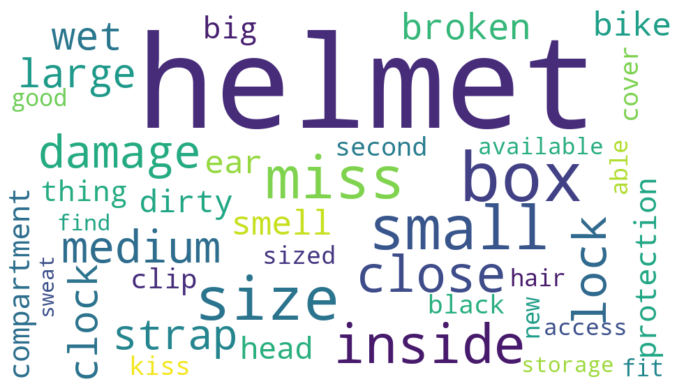

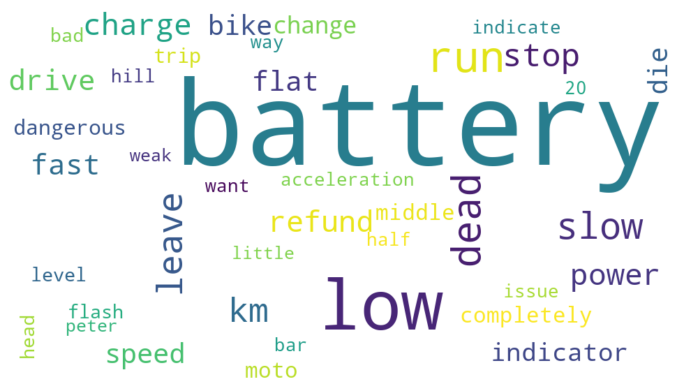

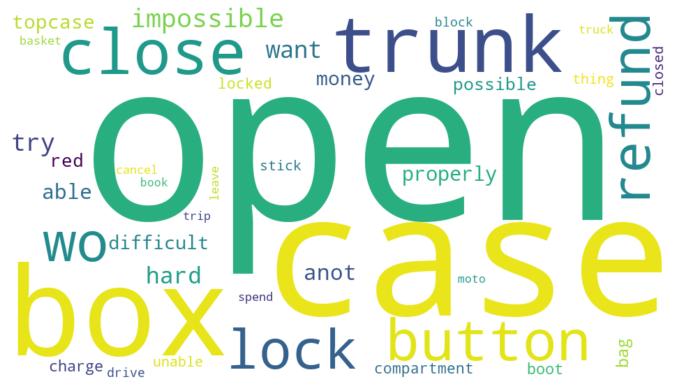

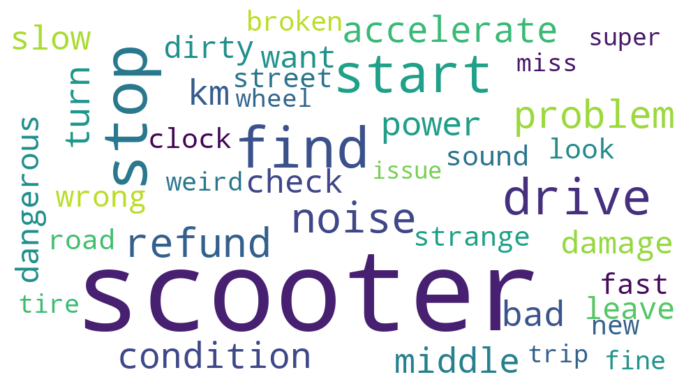

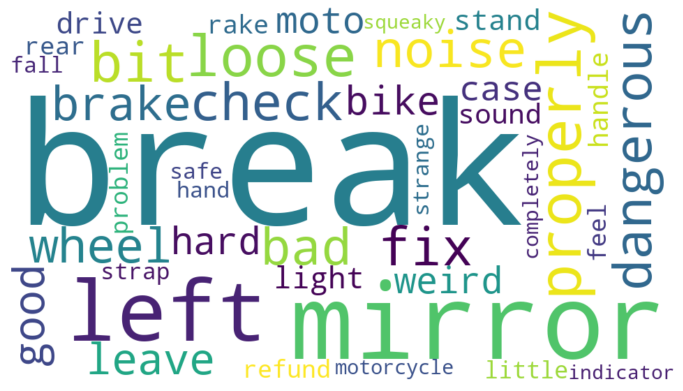

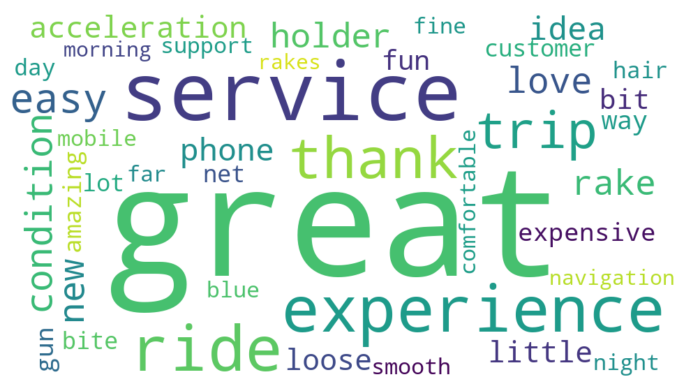

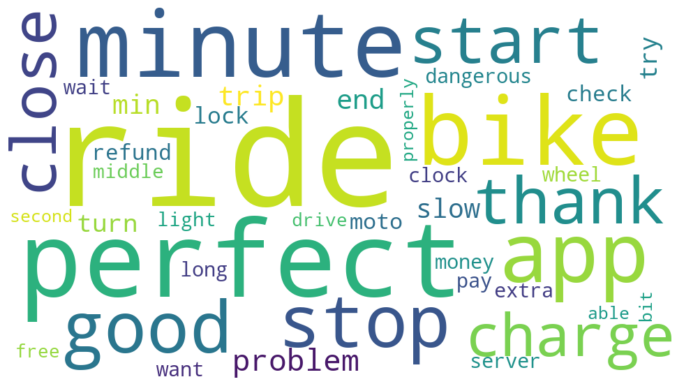

In [86]:
wordcloud_topics(nmf_text_model, tfidf_text.get_feature_names())

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


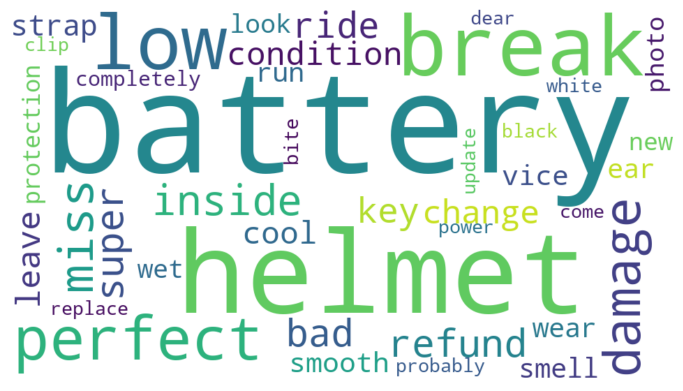

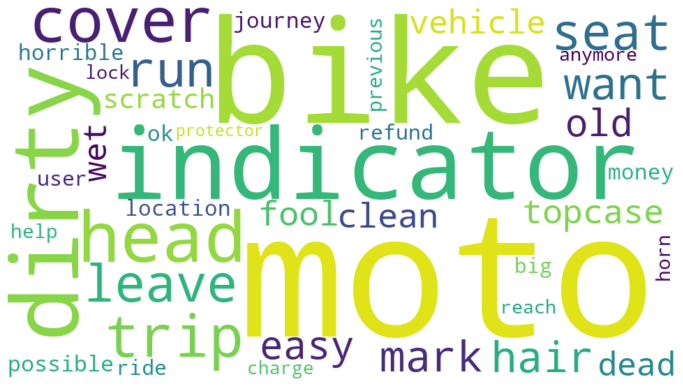

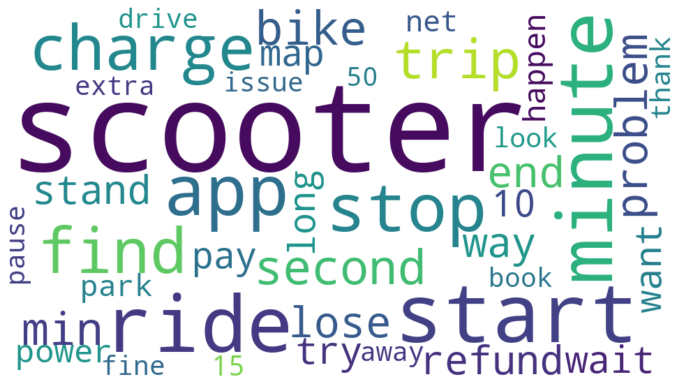

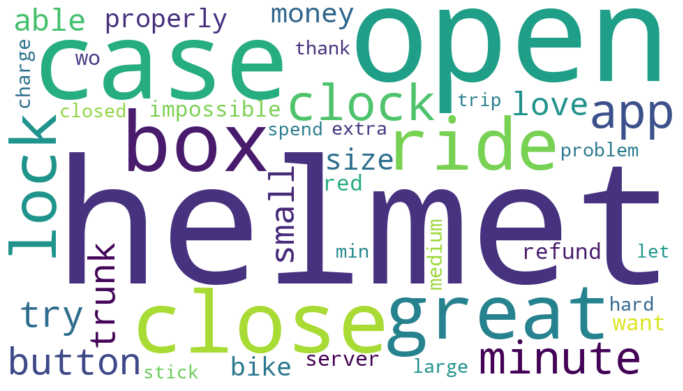

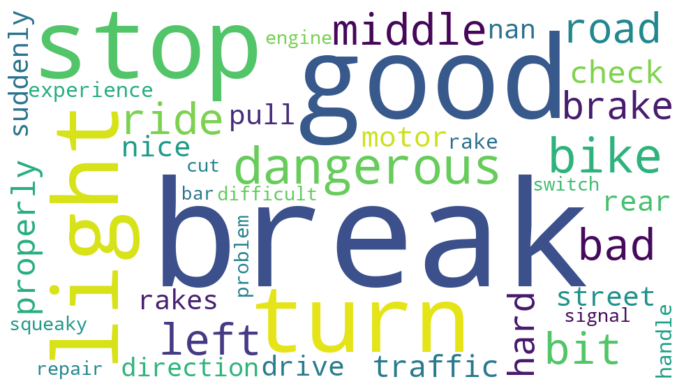

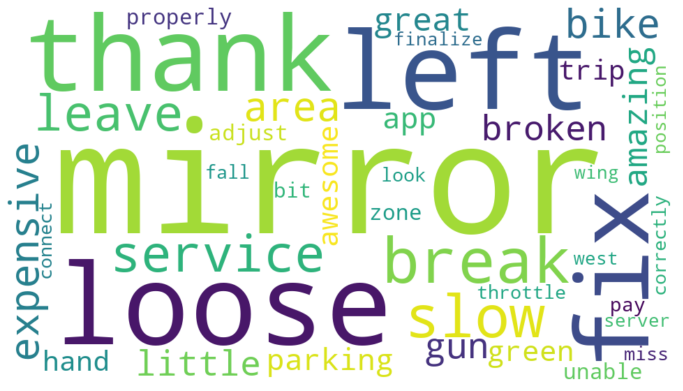

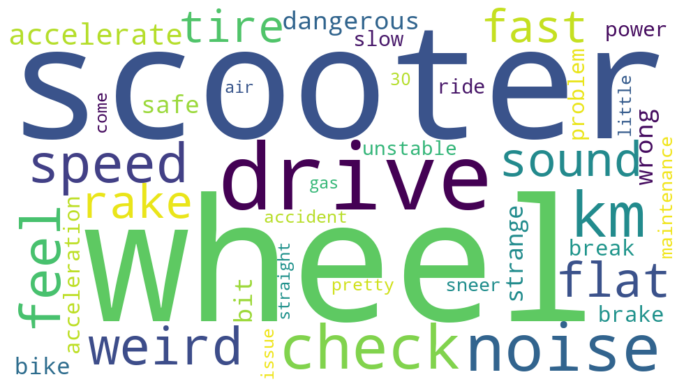

In [87]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

In [95]:
import numpy as np
year_data = []
years = np.unique(df['year'])
for year in years:
    W_year = lda_para_model.transform(count_para_vectors[df['year'] == year])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [187]:
count_para_vectors[df['year'] == year]

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<1170x993 sparse matrix of type '<class 'numpy.int64'>'
	with 4141 stored elements in Compressed Sparse Row format>

In [98]:
topic_names = []
voc = count_para_vectorizer.get_feature_names()
for topic in lda_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic battery helmet,Topic moto bike,Topic scooter start,Topic helmet open,Topic break good,Topic mirror loose,Topic wheel scooter
year,,,,,,,
2017-01-01,13.32221,8.76420,23.66855,16.52227,13.35672,12.62969,11.73635
2018-01-01,14.29833,10.86636,17.72154,18.19269,14.25357,12.00129,12.66622
2019-01-01,12.58004,9.67564,16.11595,20.59659,14.25585,12.52345,14.25248
2020-01-01,11.64431,10.76209,15.80377,18.79818,15.00873,11.99127,15.99164
2021-01-01,12.43176,11.85238,14.74151,20.49067,13.44176,11.20331,15.83860


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='year'>

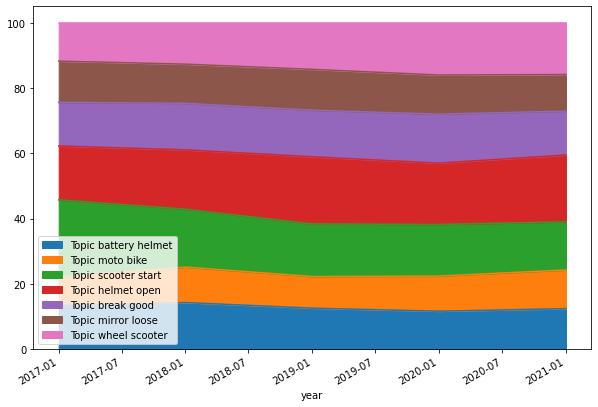

In [133]:
df_year = pd.DataFrame(year_data,columns=["year"] + topic_names).set_index("year")
df_year.index= pd.to_datetime(df_year.index,format='%Y')
df_year.plot.area(figsize=(10,7), use_index=True,x_compat=True)

In [150]:
!pip install gensim

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [152]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower())if w not in stopwords] for paragraph in df["final_msg_join"]]

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [153]:
from gensim.corpora import Dictionary
dict_gensim_para = Dictionary(gensim_paragraphs)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\T430\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\T430\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [154]:
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [155]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) \
                    for paragraph in gensim_paragraphs]

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [156]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [174]:
from gensim.models import LdaModel
lda_gensim_para = LdaModel(corpus=bow_gensim_para, id2word=dict_gensim_para,
    chunksize=2000, alpha='auto', eta='auto', iterations=400, num_topics=7, 
    passes=20, eval_every=None, random_state=42)


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [160]:

from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model=lda_gensim_para,
    texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.3973738025175145


In [169]:
from gensim.models.ldamulticore import LdaMulticore
lda_para_model_n = []
for n in range(3, 8):
    lda_model = LdaMulticore(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000, eta='auto', iterations=400, num_topics=n, passes=20, eval_every=None,random_state=42)
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_paragraphs,dictionary=dict_gensim_para, coherence='c_v')
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='n'>

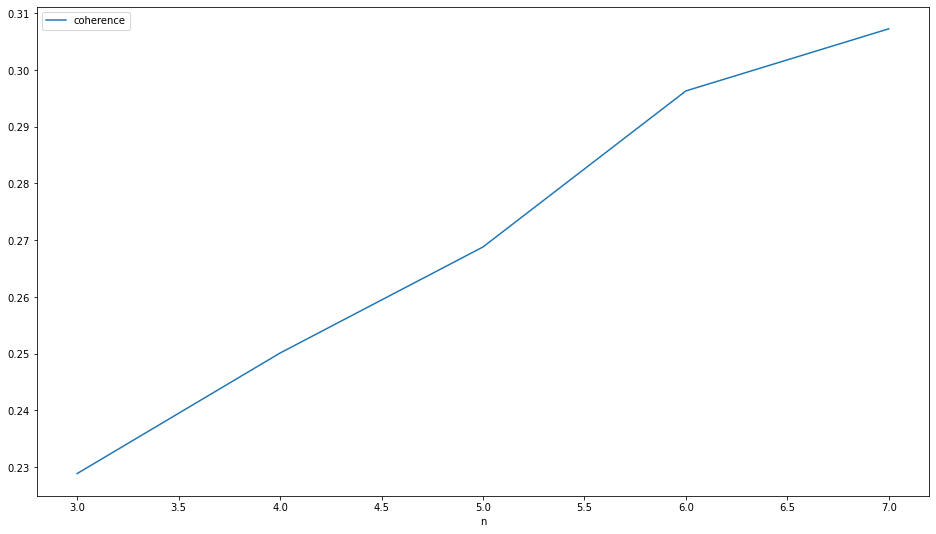

In [170]:
pd.DataFrame(lda_para_model_n, columns=["n", "model","coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))


In [175]:

LdaModel.show_topics(lda_gensim_para,)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.112*"good" + 0.088*"bad" + 0.034*"love" + 0.034*"accelerate" + 0.031*"engine" + 0.030*"head" + 0.030*"new" + 0.028*"condition" + 0.027*"service" + 0.023*"cover"'),
 (1,
  '0.099*"stop" + 0.043*"thank" + 0.029*"middle" + 0.027*"road" + 0.027*"power" + 0.025*"dangerous" + 0.024*"park" + 0.023*"flat" + 0.022*"motorbike" + 0.020*"area"'),
 (2,
  '0.233*"scooter" + 0.063*"start" + 0.052*"slow" + 0.047*"problem" + 0.035*"trip" + 0.029*"find" + 0.024*"super" + 0.023*"end" + 0.018*"soto" + 0.018*"look"'),
 (3,
  '0.242*"helmet" + 0.160*"open" + 0.081*"case" + 0.050*"box" + 0.029*"close" + 0.025*"lock" + 0.023*"button" + 0.021*"trunk" + 0.016*"small" + 0.015*"miss"'),
 (4,
  '0.142*"battery" + 0.058*"bike" + 0.047*"refund" + 0.043*"km" + 0.041*"try" + 0.040*"want" + 0.034*"money" + 0.033*"low" + 0.028*"charge" + 0.028*"speed"'),
 (5,
  '0.106*"break" + 0.043*"mirror" + 0.035*"drive" + 0.035*"bike" + 0.032*"leave" + 0.032*"left" + 0.032*"wheel" + 0.027*"bit" + 0.025*"check" + 0.025*"tu

In [176]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_gensim_para, vectors_gensim_para, tfidf_gensim_para, sort_topics=False)
pyLDAvis.display(lda_display)

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'TfidfModel' object has no attribute 'get_feature_names'

In [177]:
lda_gensim_para[corpus]

C:\Users\T430\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'corpus' is not defined